# Transformer Training

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

from transformer_model import *
import nltk
import sys
import matplotlib.pyplot as plt
sys.path.append("../../..")

from statapp.common.preprocessing import load_all_data, encode_data, split_into_X_y

from statapp.common.sampling import sample_token_sequence

## Preprocessing

Preprocessing maison assez brouillon pour le moment... L'encodage est effectué au niveau des mots. Les données exploitées sont placées dans le dossier data dans le dossier du notebook.

In [5]:
vocab_size = 50

In [6]:
text = load_all_data("data/fr.train.top1M.txt", sample=0.00001)

tokens = nltk.word_tokenize(text)

vocab = list(set(tokens))

In [7]:
dico = {}

for word in vocab:
    dico[word]=0
    
for token in tokens:
    dico[token]+=1
    
sorted_list = sorted(dico.items(), key=lambda x: x[1], reverse=True)

sorted_dico = {}

for i in range(vocab_size-1):
    sorted_dico[sorted_list[i][0]] = sorted_list[i][1]

In [8]:
for i in range(len(tokens)):
    if tokens[i] not in sorted_dico:
        tokens[i] = "<unk>"

In [9]:
vocab = list(set(tokens))

vocab_numbers = dict(zip(vocab, range(0,len(vocab))))
vocab_numeroted = dict(zip(range(0,len(vocab)), vocab))
tokens_numbers = np.array([vocab_numbers[tokens[i]] for i in range(len(tokens))])

tokens_numbers_sequences = np.array([ tokens_numbers[i:i+max_length+1] for i in range(len(tokens_numbers)-max_length)])
tokens_numbers_sequences = torch.tensor(tokens_numbers_sequences , dtype=torch.int64)

nb_sequences =  tokens_numbers_sequences.shape[0]

print("Les données exploitées contiennent {} tokens (mots) au total.".format(len(tokens)))
print("La taille du vocabulaire ainsi constitué est de {}".format(vocab_size))

Les données exploitées contiennent 553 tokens (mots) au total.
La taille du vocabulaire ainsi constitué est de 50


In [8]:
"""text_test = load_all_data("data/fr.train.top1M.txt", sample=0.05, part="end")

tokens_test = nltk.word_tokenize(text_test)

vocab_test = list(set(tokens_test))

vocab_size_test = len(vocab_test)

vocab_numbers_test = dict(zip(vocab_test, range(0,len(vocab_test))))
vocab_numeroted_test = dict(zip(range(0,len(vocab_test)), vocab_test))
tokens_numbers_test = np.array([vocab_numbers_test[tokens_test[i]] for i in range(len(tokens_test))])

tokens_numbers_sequences_test = np.array([ tokens_numbers_test[i:i+max_length+1] for i in range(len(tokens_numbers_test)-max_length)])
tokens_numbers_sequences_test = torch.tensor(tokens_numbers_sequences_test , dtype=torch.int64)

nb_sequences_test =  tokens_numbers_sequences_test.shape[0]

print("Les données exploitées contiennent {} tokens (mots) au total.".format(len(tokens_test)))
print("La taille du vocabulaire ainsi constitué est de {}".format(vocab_size_test))"""

'text_test = load_all_data("data/fr.train.top1M.txt", sample=0.05, part="end")\n\ntokens_test = nltk.word_tokenize(text_test)\n\nvocab_test = list(set(tokens_test))\n\nvocab_size_test = len(vocab_test)\n\nvocab_numbers_test = dict(zip(vocab_test, range(0,len(vocab_test))))\nvocab_numeroted_test = dict(zip(range(0,len(vocab_test)), vocab_test))\ntokens_numbers_test = np.array([vocab_numbers_test[tokens_test[i]] for i in range(len(tokens_test))])\n\ntokens_numbers_sequences_test = np.array([ tokens_numbers_test[i:i+max_length+1] for i in range(len(tokens_numbers_test)-max_length)])\ntokens_numbers_sequences_test = torch.tensor(tokens_numbers_sequences_test , dtype=torch.int64)\n\nnb_sequences_test =  tokens_numbers_sequences_test.shape[0]\n\nprint("Les données exploitées contiennent {} tokens (mots) au total.".format(len(tokens_test)))\nprint("La taille du vocabulaire ainsi constitué est de {}".format(vocab_size_test))'

## Apprentissage du modèle

In [10]:
LMtransformer = buildTransformer(vector_size, nb_decoders, nb_heads, head_size, ffn_hidden_size, vocab_size)
#Correspond à utiliser l'entropie croisée puisque les sorties sont des log_softmax
#et l'entropie croisée = nll_loss(log_softmax(.), target)
criterion = nn.NLLLoss()
optimizer = optim.Adam(LMtransformer.parameters(), lr=0.01)

In [11]:
def train_model(nb_epochs, batch_size):
    
    #What is this ?? I don't remember. Make grad required ?
    LMtransformer.train()
    
    #pas pour l'affichage progressif de la loss
    step = max(1,((len(tokens)-max_length-1)/batch_size)//5)
    
    epochs_losses = []
    losses = []
    
    for epoch in range(nb_epochs):
        
        running_loss = 0
        
        randperm = torch.randperm(nb_sequences)
        randperm = randperm[:(nb_sequences//batch_size)*batch_size]
        batchs_indices = randperm.reshape(nb_sequences//batch_size, batch_size)
        
        
        # running_loss_test = 0
        
        # randperm_test = torch.randperm(nb_sequences_test)
        #randperm_test = randperm_test[:(nb_sequences//batch_size)*batch_size]
        #batchs_indices_test = randperm_test.reshape(nb_sequences_test//batch_size, batch_size)
        
        
        for i, batch_indices in enumerate(batchs_indices):
            
            batch = tokens_numbers_sequences[batch_indices]
            optimizer.zero_grad()
            output = LMtransformer(batch[:,:-1])
            loss = criterion(output.reshape(-1, vocab_size), batch[:,1:].flatten())

            loss.backward()
            optimizer.step()
            
            #Il faudrait adapter les affichages en fonction du nombre de batchs total
            running_loss += loss.item()
            if i % step == step-1:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / step))
                
                #stock pour affichage graphique
                epochs_losses.append(epoch-1+(i/((len(tokens)-max_length-1)/batch_size)))
                losses.append(running_loss / step)
                
                running_loss = 0.
                
        plt.plot(epochs_losses, losses)

Test d'overfitting sur un cas ultrasimplifié (5 tokens, longueur de séquence 1, 3 decoders, 2 heads) :
- En observant les sorties le modèle a bien appris et overfitte ! (loss à 0 au bout de 5-6 epochs) 

C:\Users\Eric\statapp_language_model\statapp\transformer\pytorch\transformer_model.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(torch.add(embedded, pos_encodings), dtype=torch.float32)


[1,    10] loss: 3.253
[1,    20] loss: 2.145
[1,    30] loss: 1.894
[1,    40] loss: 1.801
[1,    50] loss: 1.735
[2,    10] loss: 1.524
[2,    20] loss: 1.462
[2,    30] loss: 1.502
[2,    40] loss: 1.579
[2,    50] loss: 1.482
[3,    10] loss: 1.316
[3,    20] loss: 1.382
[3,    30] loss: 1.351
[3,    40] loss: 1.355
[3,    50] loss: 1.357
[4,    10] loss: 1.276
[4,    20] loss: 1.311
[4,    30] loss: 1.350
[4,    40] loss: 1.459
[4,    50] loss: 1.326
[5,    10] loss: 1.280
[5,    20] loss: 1.332
[5,    30] loss: 1.297
[5,    40] loss: 1.274
[5,    50] loss: 1.444


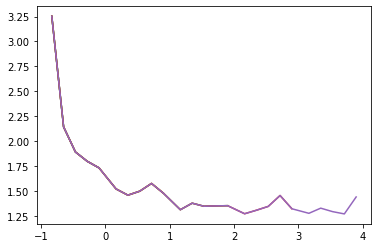

In [12]:
train_model(5,10)

## Sauvegarde des paramètres du modèle obtenu

In [8]:
#Attention : pas sûr que les hyperparamètres soient sauvegardés également
torch.save(LMtransformer.state_dict(), "params/LMtfparams"+str(np.random.rand())[2:])

In [14]:
#Later to restore: 
#LMtransformer.load_state_dict(torch.load("params"))

<All keys matched successfully>

## Génération

In [36]:
#bidouilles pour adapter nos fonctions aux fonctions common codées par Nathra 
#(sequence list of ints en entree, list of probas en sortie)
#(Faire mieux plus tard)
def LMtransformerprediction(listints):
    return np.exp(LMtransformer(torch.tensor([listints[-8:]]))[0][-1].tolist())

In [37]:
def gen_seq(prev_seq, top_k=5):
    with torch.no_grad():
        prev_seq_numbers = [vocab_numbers[token] for token in prev_seq]
        sample_token_seq = sample_token_sequence(LMtransformerprediction, prev_seq_numbers, top_k=top_k)
        tokens_pred = [vocab_numeroted[i] for i in sample_token_seq]
        print(' '.join(tokens_pred)) 

In [38]:
def gen_seq_maison(prev_seq):
    with torch.no_grad():
        prev_seq_numbers = [vocab_numbers[token] for token in prev_seq]
        indice = np.argmax(np.array(LMtransformer(torch.tensor([prev_seq_numbers]))))
        tokens_pred = vocab_numeroted[indice]
        print(' '.join(tokens_pred))

In [39]:
gen_seq(['il'])

100%|████████████████████████████████████████| 100/100 [00:01<00:00, 96.99it/s]


est <unk> de <unk> <unk> de la <unk> de la <unk> <unk> des a <unk> , par <unk> <unk> <unk> <unk> <unk> et la <unk> , <unk> <unk> et des <unk> et des <unk> , l ' <unk> <unk> <unk> . <unk> <unk> la <unk> <unk> et la <unk> <unk> <unk> <unk> <unk> `` d ' <unk> <unk> . <unk> , la <unk> <unk> <unk> de l ' <unk> <unk> <unk> , `` <unk> comme <unk> , `` ) . en <unk> , en <unk> , les <unk> de vitoria-gasteiz pour <unk> , on , les <unk> en <unk> en


In [40]:
gen_seq(['a','l','<unk>','de','31'], top_k=1)

100%|███████████████████████████████████████| 100/100 [00:00<00:00, 100.20it/s]


<unk> , il est <unk> par l ' il <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>


In [25]:
gen_seq(['<unk>','<unk>','<unk>','<unk>','<unk>','<unk>','<unk>','<unk>','<unk>','<unk>','<unk>','<unk>','<unk>','<unk>','<unk>','<unk>'], top_k=1)

100%|████████████████████████████████████████| 100/100 [00:01<00:00, 54.67it/s]


<unk> <unk> <unk> <unk> et <unk> `` d ' <unk> . <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> . <unk> . <unk> , les <unk> <unk> . <unk> . <unk> , les <unk> . <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>


In [20]:
gen_seq(['barcelone',',','il','est','touche','par','l'])

100%|████████████████████████████████████████| 100/100 [00:02<00:00, 44.75it/s]


' esprit prophetique apres avoir obtenu la connaissance du vrai nom de dieu . il est alors persuade d ' esprit prophetique apres avoir obtenu la connaissance du vrai nom de dieu . il est alors persuade d ' esprit prophetique apres avoir obtenu la connaissance du vrai nom de dieu . il est alors persuade d ' esprit prophetique apres avoir obtenu la connaissance du vrai nom de dieu . il est alors persuade est alors persuade d ' esprit prophetique apres avoir obtenu la connaissance du vrai nom de dieu . il est alors persuade d ' esprit


In [20]:
if len(tokens)<100:
    print(' '.join(tokens))